# Tutorial 1


## Frequency domain

### 3D layered model with boxes

This model consists of a stack of horizontal layers with the top of the first layer being at the sea level and the last layer having infinite thickness. 



In [1]:
import requests
import json
import numpy
import time


print('Init ...')


api_key='<insert your API key from e-mail here>'

# alternatively put your API key to api.key file
if api_key[0]=='<':
    with open ("api.key", "r") as keyfile:
        api_key=keyfile.read()
    
    
headers = {'x-api-key': api_key,'Content-Type': 'application/json'}



Init ...




First define model parameter and subroutine to submit modelling tasks to the API.



In [2]:

print('Define model ...')

model = {
    'model_type': 'layered_with_boxes',
    'layer_thicknesses':   [  500, 1000, 200, 400 ],
    'layer_resistivities': [ 0.25,    2,   4,   3, 6 ],
    'seafloor_at_layer' : 0,
    'source_altitude' : 30,
    'source_length' : 275,
    'frequency' : 0.25,
    'boxes' : 
    [
        {
            'active': True,
            'resistivity': 100,
            'center_x': 2000,
            'center_y': 0,
            'width_x':3000,
            'width_y':2500,
            'top_depth': 700,
            'base_depth': 900       
        },
        {
            'active': True,
            'resistivity': 100,
            'center_x': 4000,
            'center_y': 3000,
            'width_x':2000,
            'width_y':2500,
            'top_depth': 600,
            'base_depth': 700       
        }
    ]
}


def submit_task(model):

    
    try:
         r = requests.post('https://api.geotech.no/model', headers=headers, json=model )    

    except requests.exceptions.ConnectionError as e:     
        print("Error: " + str(e))
        return
    
    print(r.text)
    print('\t',json.loads(r.json()))

    return json.loads(r.json())['task_id']


Define model ...


In [15]:

print("Select receiver positions: line along X axis, and Y=0")

x,y = numpy.mgrid[-15000:15000:500j, 0:0:1j]

model['receiver_x'] = x.flatten().tolist()
model['receiver_y'] = y.flatten().tolist()


Select receiver positions: line along X axis, and Y=0


In [4]:
print('Submitting modelling task ...')
task_id=submit_task(model)

# API call limit is set to 1 per second, do not call it too often
time.sleep(1.5)

Submitting modelling task ...
"{\"status\": \"SUCCESS\", \"task_id\": \"193b6bb8-580b-43c5-8f8a-eab19433b3f9\"}"

	 {'status': 'SUCCESS', 'task_id': '193b6bb8-580b-43c5-8f8a-eab19433b3f9'}


In [5]:

def wait_for_data(task_id):
  n=0
  while True:

    try:
        s = requests.get('https://api.geotech.no/data/'+task_id, headers=headers )
    except requests.exceptions.HTTPError as e:     
        print("Error: " + str(e))
        return
    
    status = json.loads(s.json())['status']
    
    n+=2
    print('\r',n,s,'\t',status,end='             ')
    if status == "READY":
        break
    
    if status == "ERROR":
        print(s.text)
        return 0,0,0
        break
    
    time.sleep(2)
  
  ex=numpy.array(json.loads(s.json())['ex'])
  ex=ex[:,0]+ex[:,1]*1j
  ey=numpy.array(json.loads(s.json())['ey'])
  ey=ey[:,0]+ey[:,1]*1j
  ez=numpy.array(json.loads(s.json())['ez'])
  ez=ez[:,0]+ez[:,1]*1j
 

  return ex,ey,ez

    

In [6]:
print('Collecting modelling results ... for task ' + task_id)
ex,ey,ez=wait_for_data(task_id)

 138 <Response [200]> 	 READY                 

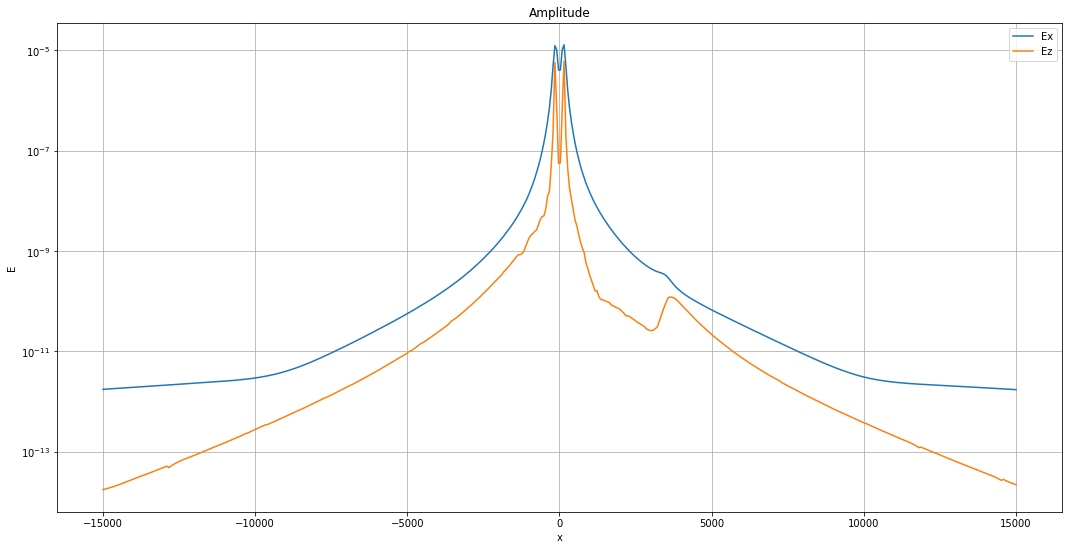

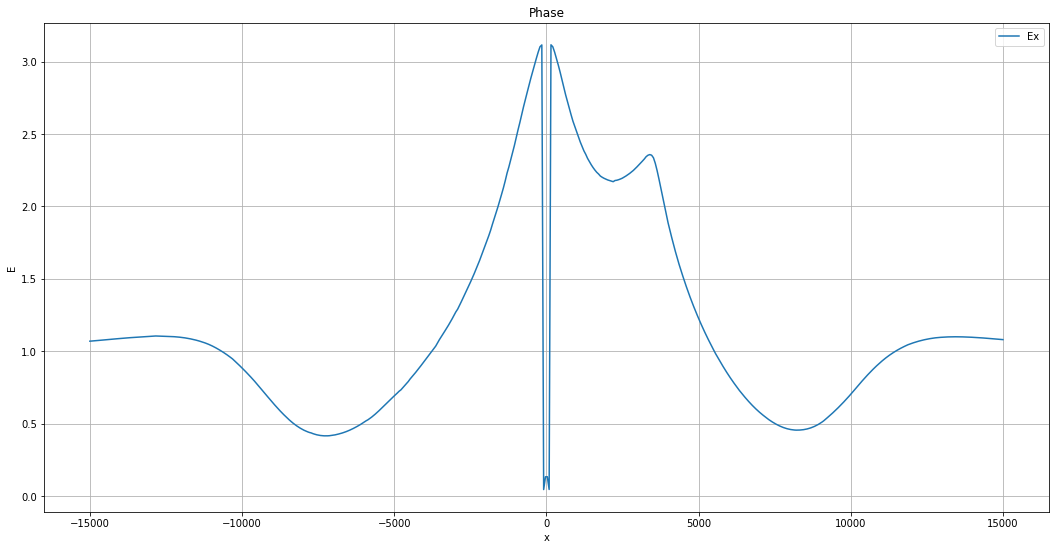

In [16]:


import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18, 9]
plt.grid(True)
plt.semilogy(model['receiver_x'],[abs(x) for x in ex],label='Ex') 
plt.semilogy(model['receiver_x'],[abs(x) for x in ez],label='Ez') 
plt.xlabel('x')
plt.ylabel('E')
plt.title("Amplitude")
plt.legend()
plt.show()    
 
import cmath

plt.grid(True)
plt.plot(model['receiver_x'],[cmath.phase(x) for x in ex],label='Ex')
plt.xlabel('x')
plt.ylabel('E')
plt.title("Phase")
plt.legend()
plt.show()    

    

In [8]:

print("Select receiver positions: uniform grid 50x50 points in XY plane")

ndx=50j
x,y = numpy.mgrid[-12000:12000:ndx, -12000:12000:ndx]

model['receiver_x'] = x.flatten().tolist()
model['receiver_y'] = y.flatten().tolist()



Select receiver positions: uniform grid 50x50 points in XY plane


In [9]:
task_id2=submit_task(model)

"{\"status\": \"SUCCESS\", \"task_id\": \"2b32de21-108a-4012-8ff7-bd3860cb7bab\"}"

	 {'status': 'SUCCESS', 'task_id': '2b32de21-108a-4012-8ff7-bd3860cb7bab'}


In [10]:
print('Collecting modelling results ... for task ' + task_id)
ex2,ey2,ez2=wait_for_data(task_id2)

 144 <Response [200]> 	 READY                 

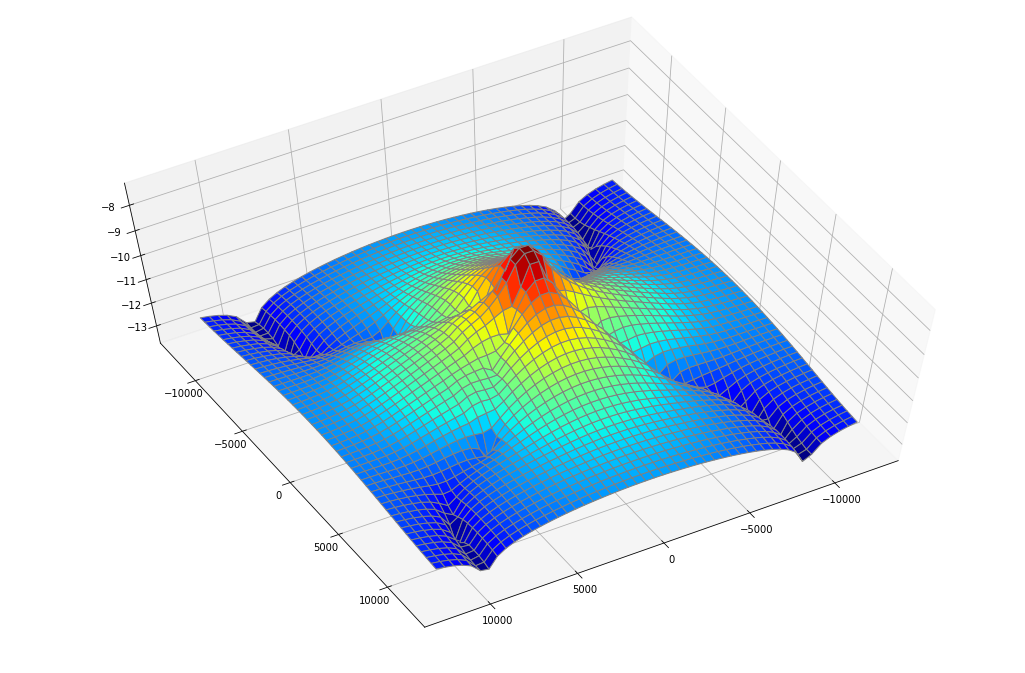

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import cmath


exr=numpy.log10(abs(ex2.reshape(len(x),len(y))))

plt.rcParams['figure.figsize'] = [18, 12]
ax = plt.axes(projection='3d')
ax.view_init(65, 60)
ax.plot_surface(x, y, exr, rstride=1, cstride=1, cmap='jet', edgecolor='grey');




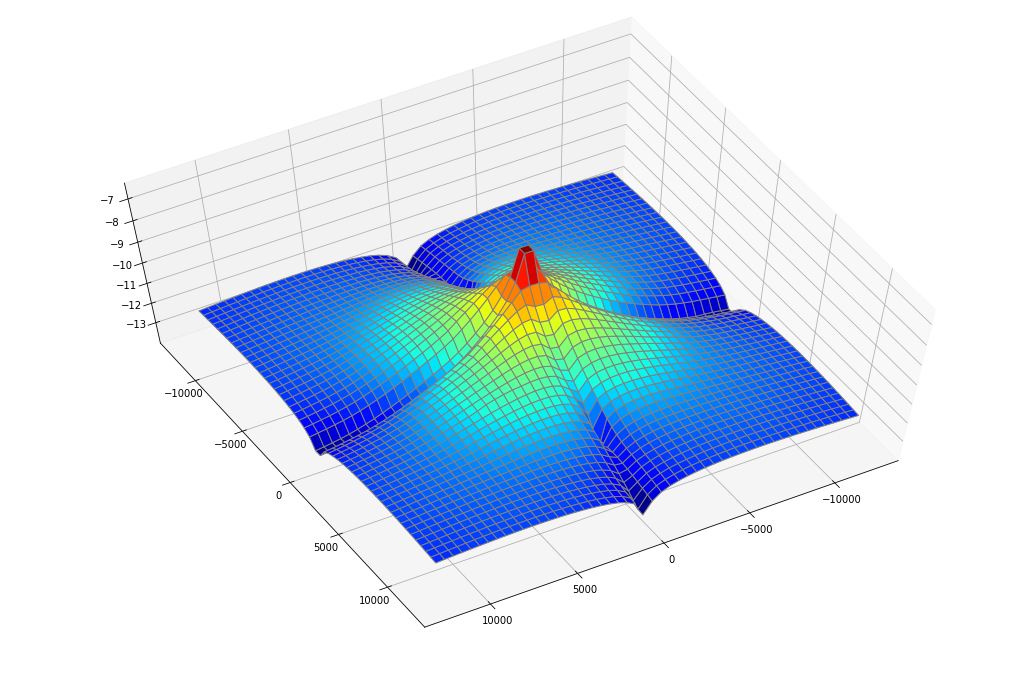

In [12]:
exr=numpy.log10(abs(ey2.reshape(len(x),len(y))))

plt.rcParams['figure.figsize'] = [18, 12]
ax = plt.axes(projection='3d')
ax.view_init(65, 60)
ax.plot_surface(x, y, exr, rstride=1, cstride=1,cmap='jet', edgecolor='grey');


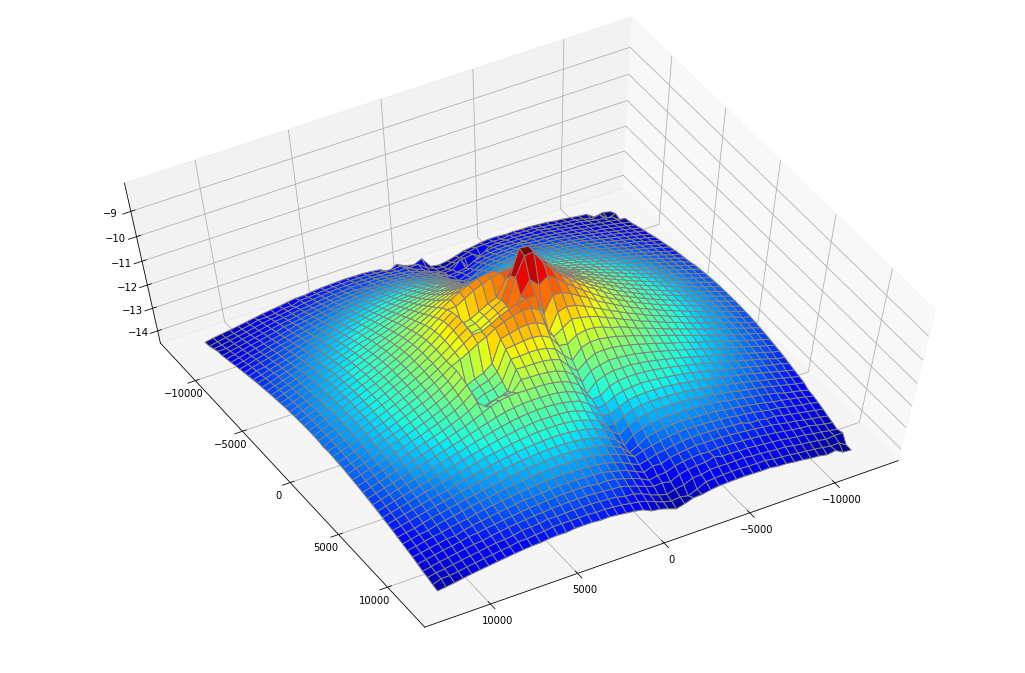

In [13]:
exr=numpy.log10(abs(ez2.reshape(len(x),len(y))))

plt.rcParams['figure.figsize'] = [18, 12]
ax = plt.axes(projection='3d')
ax.view_init(65, 60)
ax.plot_surface(x, y, exr, rstride=1, cstride=1,cmap='jet', edgecolor='grey');
